## **Obesity Prediction**

The purpose of the following script is to accurately predict obesity based off of biological, lifestyle, and personal demographic features

This project contains 4 models:

1. Baseline Random Classifier
2. Statistical Multinominal Logistic Regression
3. Probabilistic Gaussian Naive Bayes
4. Multi-layer Perceptron Neural Network

In [2]:
#______1: Preprocess the data______

#import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix

#import the data
data_raw = pd.read_csv('obesity_data.csv')
metabolites = pd.read_csv('metabolites.csv')

#clean the data
data = pd.DataFrame(data_raw)

data.rename(columns={"Gender":"gender", "Age":"age", "Height":"height (m)",
                     "Weight":"weight (kg)",
                     "family_history_with_overweight":"fam_history_overweight",
                     "FAVC":"high_calorie_freq", "FCVC":"vegetable_freq",
                     "NCP":"num_meals_daily", "CAEC":"food_between_meals",
                     "SMOKE":"smoke", "CH2O":"water_intake", "SCC":"count_calories",
                     "FAF":"physical_activity_freq", "TUE":"technology_use_time",
                     "CALC":"alcohol_freq", "MTRANS":"transportation",
                     "NObeyesdad":"obesity"}, inplace=True)

#drop null values
data.dropna(inplace=True)

#convert gender to boolean
data['gender'] = data['gender'].map({'Male': 1, 'Female': 0})

#convert catgorial yes/no to boolean
data['fam_history_overweight'] = data['fam_history_overweight'].map({'yes': 1, 'no': 0})
data['high_calorie_freq'] = data['high_calorie_freq'].map({'yes': 1, 'no': 0})
data['smoke'] = data['smoke'].map({'yes': 1, 'no': 0})
data['count_calories'] = data['count_calories'].map({'yes': 0, 'no': 1})

#convert ordinal variables to numerical
data['food_between_meals'] = data['food_between_meals'].map({'no': 1,
                                                     'Sometimes': 2,
                                                     'Frequently': 3,
                                                     'Always': 4})
data['alcohol_freq'] = data['alcohol_freq'].map({'no': 1,
                                                'Sometimes': 2,
                                                'Frequently': 3,
                                                'Always': 4})
data['obesity'] = data['obesity'].map({'Insufficient_Weight':1,
                                       'Normal_Weight': 2,
                                       'Overweight_Level_I': 3,
                                       'Overweight_Level_II':4,
                                       'Obesity_Type_I': 5,
                                       'Obesity_Type_II': 6,
                                       'Obesity_Type_III': 7})

#OHE transportation so it's values are equal
data = pd.get_dummies(data, columns=['transportation'], prefix='transportation')

#add BMI column
data['bmi'] = data['weight (kg)'] / (data['height (m)'] ** 2)

#map the metabolites based on weight class
def assign_metabolites(row):
    assigned_values = np.zeros(len(metabolites.columns))

    if row['obesity'] == 1:
        assigned_values[:7] = metabolites[['benzoate', '1_5_anhydroglucitol_1_5_AG',
                                           'palmitoyl_sphingomyelin', 'asparagine',
                                           'histidine', 'glycine', 'n_acetylglycine']].values[0]
    elif row['obesity'] == 2:
        assigned_values[:5] = metabolites[['3_hydroxyisobutyrate', 'lactate',
                                           '1_oleoglycerophosphocholine',
                                           '1_eicosadienoylglycerophosphocholine',
                                           '2_linoleooylglycerphosphocholine']].values[0]
    elif row['obesity'] == 3:
        assigned_values[:5] = metabolites[['alpha_hydroxyisovalerate', 'propionylcarnitine',
                                           '3_methyl_2_oxovalerate', 'carnitine',
                                           '4_methyl_2_oxopentanoate']].values[0]
    elif row['obesity'] == 4:
        assigned_values[:5] = metabolites[['gamma_glutamylisoleucine', '7_HOCA', 'glycerol',
                                           'phenylalanine', 'hexanoylcarnitine']].values[0]
    elif row['obesity'] == 5:
        assigned_values[:5] = metabolites[['andro_steroid_monosulfate_2', '2_hydroxybutyrate_AHB',
                                           'lathosterol', '3_methyl_2_oxobutyrate', 'kynurenine']].values[0]
    elif row['obesity'] == 6:
        assigned_values[:5] = metabolites[['tyrosine', 'leucine', '3_4_hydroxyphenyl_lactate',
                                           'gamma_glutamyltyrosine', 'butyrylcarnitine']].values[0]
    elif row['obesity'] == 7:
        assigned_values[:5] = metabolites[['glutamate', 'valine', 'mannose',
                                           'isovalerylcarnitine', 'isoleucine']].values[0]

    return assigned_values

#add metabolites columns
metabolite_values = data.apply(assign_metabolites, axis=1)
metabolite_df = pd.DataFrame(metabolite_values.tolist(), columns=metabolites.columns)

# fill null values in metabolite DF with 0
metabolite_df.fillna(0, inplace=True)

#concatenate metabolite data with the main data
data = pd.concat([data.reset_index(drop=True), metabolite_df.reset_index(drop=True)], axis=1)

#drop duplicates
data = data.drop_duplicates()

#define x and y
X = data.drop('obesity', axis=1)
y = data['obesity']

#split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#view the cleaned dataset
data.head(5)

,gender,age,height (m),weight (kg),fam_history_overweight,high_calorie_freq,vegetable_freq,num_meals_daily,food_between_meals,smoke,...,2_linoleooylglycerphosphocholine,3_methyl_2_oxovalerate,gamma_glutamylisoleucine,carnitine,benzoate,4_methyl_2_oxopentanoate,3_hydroxyisobutyrate,1_eicosadienoylglycerophosphocholine,lactate,1_oleoglycerophosphocholine
0,0,21.0,1.62,64.0,1,0,2.0,3.0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,21.0,1.52,56.0,1,0,3.0,3.0,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,23.0,1.80,77.0,1,0,2.0,3.0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,27.0,1.80,87.0,0,0,3.0,3.0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,22.0,1.78,89.8,0,0,2.0,1.0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[4 3 3 3 7 6 5 2 4 7 1 6 1 3 4 5 6 2 3 7 3 7 3 4 2 2 4 3 2 5 2 1 4 5 2 3 3
 5 3 1 1 7 7 2 4 6 3 4 1 4 3 3 1 2 2 1 1 7 2 7 2 3 1 2 6 1 3 7 2 2 5 3 5 3
 5 2 7 5 4 7 4 1 6 5 2 2 7 2 6 1 5 3 2 2 3 3 6 1 2 5 6 3 1 4 4 1 4 6 7 6 6
 2 1 2 1 4 7 3 5 5 1 5 2 3 4 3 5 4 5 6 3 7 7 6 5 6 5 1 7 7 1 7 4 4 3 4 5 3
 2 1 3 1 3 5 2 1 4 7 6 6 2 1 4 5 6 3 6 5 1 6 7 1 5 4 1 5 4 3 1 3 5 6 1 3 2
 5 6 2 3 1 2 6 4 4 3 6 4 5 6 3 7 5 3 6 7 2 1 1 2 6 7 7 1 2 4 3 7 3 4 7 3 6
 3 2 1 4 7 1 7 1 6 4 6 4 5 1 5 3 3 4 4 1 1 4 1 2 5 1 7 6 7 4 5 7 1 4 3 1 5
 6 1 4 3 1 7 7 5 6 4 1 1 3 6 4 7 2 1 5 2 6 4 5 4 5 3 7 6 6 3 6 2 5 7 4 7 6
 4 6 1 4 5 7 4 5 5 7 6 5 1 5 3 2 7 4 2 7 1 5 6 7 2 1 7 6 4 6 7 2 2 6 3 2 5
 2 4 7 4 4 4 6 2 3 4 1 5 4 1 2 3 5 6 2 5 5 3 6 3 5 4 2 4 5 6 7 6 2 1 1 2 2
 2 5 3 7 4 6 2 1 4 2 2 4 5 6 3 3 2 2 3 5 6 2 4 6 7 3 5 5 3 3 3 3 4 1 4 7 6
 2 7 3 5 4 6 5 7 7 3 6]
-----------------
Random Classifier Accuracy: 0.13157894736842105
-----------------


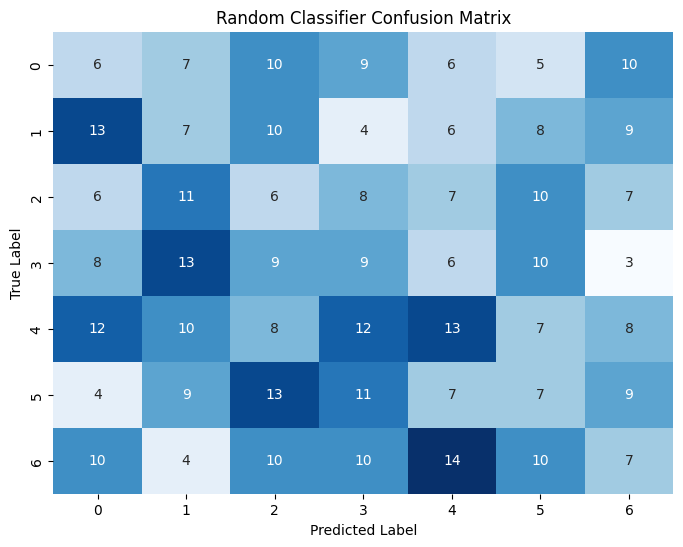

In [3]:
#________2: Baseline Random Classifier________

from sklearn.dummy import DummyClassifier

#define the random classifier
baseline_model = DummyClassifier(strategy="uniform")  # Other strategies are available

#fit the classifier to the training data (null in this case)
baseline_model.fit(X_train, y_train)

#predict the test set
y_pred_baseline = baseline_model.predict(X_test)
print(y_pred_baseline)
print('-----------------')

#evaluate the random classifier
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_cm = confusion_matrix(y_test, y_pred_baseline)
print("Random Classifier Accuracy:", baseline_accuracy)
print('-----------------')

#baseline random classifier confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(baseline_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Classifier Confusion Matrix")
plt.show()

[7 5 6 7 1 2 5 2 6 7 6 2 7 6 4 6 7 3 7 5 6 6 3 5 2 1 2 4 4 4 4 1 6 3 1 2 2
 3 1 7 3 6 1 1 6 5 6 4 3 4 7 6 2 4 5 5 4 7 6 1 3 7 5 7 7 5 1 1 3 1 1 5 7 6
 4 4 2 2 7 7 3 7 4 5 4 5 4 6 7 1 2 4 3 5 5 2 4 5 3 7 7 4 2 5 7 5 1 5 2 2 7
 4 1 3 4 7 6 4 5 3 5 7 6 6 1 3 7 3 1 1 5 3 5 6 1 6 3 3 3 3 4 7 6 1 6 5 7 6
 1 4 5 5 3 7 6 2 4 3 3 4 5 6 7 7 6 2 2 4 4 7 5 2 7 7 5 3 5 1 1 3 5 4 7 7 4
 5 6 5 4 6 3 5 3 6 5 7 6 2 1 7 4 5 1 5 2 7 7 7 5 3 3 7 2 5 3 4 2 6 3 5 6 7
 1 3 5 6 7 2 1 3 7 6 2 5 3 2 7 2 1 3 4 6 2 5 7 4 5 3 6 1 7 4 6 6 2 3 2 3 6
 3 7 5 6 3 3 1 5 6 7 5 5 1 4 6 3 6 2 2 6 4 7 4 5 6 2 1 2 3 1 6 6 7 2 7 6 2
 1 2 7 3 6 5 5 6 2 5 3 7 5 6 5 3 6 1 5 2 3 7 4 6 4 1 5 7 5 4 2 3 1 1 5 4 7
 2 5 1 2 1 1 4 4 6 4 2 4 2 2 6 1 5 3 2 5 1 7 3 2 5 6 2 1 5 5 5 4 3 1 2 4 4
 2 1 4 1 6 6 2 7 4 5 6 6 1 1 7 4 7 7 1 5 6 1 5 3 7 2 6 3 3 7 7 2 1 4 3 2 4
 5 2 3 4 2 3 2 3 1 4 5]
-----------------
Multinominal Logistic Regression Accuracy: 0.9784688995215312
-----------------


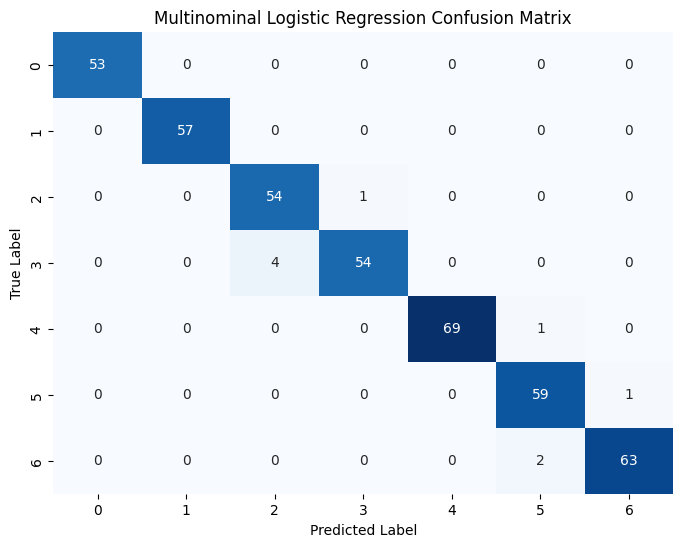

In [4]:
#________3: Multinomial Logistic Regression________

from sklearn.linear_model import LogisticRegression

#define the model
lr_model = LogisticRegression(solver='lbfgs') #lbfgs is used for its ability to handle large, high dimensional data

#fit the model to the training data
lr_model.fit(X_train, y_train)

#predict the test set
y_pred_lr = lr_model.predict(X_test)
print(y_pred_lr)
print('-----------------')

#evaluate the model
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_cm = confusion_matrix(y_test, y_pred_lr)
print("Multinominal Logistic Regression Accuracy:", lr_accuracy)
print('-----------------')

#multinominal logistic regression confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multinominal Logistic Regression Confusion Matrix")
plt.show()

In [5]:
#___4
#confirm that the model is not overfitting

#shuffle target labels
y_shuffled = np.random.permutation(y)

# Train and evaluate on shuffled data
lr_model.fit(X_train, y_shuffled[:len(X_train)])
y_pred_shuffled = lr_model.predict(X_test)
print("Accuracy on Shuffled Data:", accuracy_score(y_test, y_pred_shuffled))

Accuracy on Shuffled Data: 0.22488038277511962


[5 6 3 1 6 3 4 7 1 2 6 5 7 2 4 3 3 6 4 3 7 3 2 1 5 5 1 1 1 5 2 2 5 6 4 7 2
 2 1 2 2 5 3 7 2 3 6 3 2 7 4 1 5 7 7 7 3 5 4 3 4 5 2 6 2 6 5 3 4 5 4 2 5 2
 5 1 6 2 1 1 3 3 7 5 1 1 6 4 2 5 6 6 6 6 5 6 5 7 4 7 2 4 5 4 2 2 1 3 7 5 2
 6 5 1 7 6 3 6 2 6 1 3 5 1 3 7 3 2 3 3 6 1 4 5 3 5 4 2 3 3 7 3 3 2 7 2 3 7
 7 4 1 7 7 5 1 6 1 7 7 5 2 6 6 1 6 2 2 7 4 2 5 1 6 3 1 4 4 5 4 2 1 2 6 6 1
 4 2 6 4 5 6 6 5 2 7 2 5 3 4 2 5 7 5 3 4 5 5 4 3 5 2 6 6 4 6 6 7 7 4 7 5 1
 3 7 5 6 3 7 4 3 5 4 2 3 1 6 4 7 5 6 1 4 7 3 6 2 2 3 6 7 4 7 2 2 5 1 7 2 7
 5 5 3 6 7 5 3 2 1 5 7 1 7 6 6 2 5 4 6 2 2 4 4 5 3 5 2 6 7 6 1 3 5 5 4 5 2
 2 7 1 3 5 1 1 1 2 6 6 6 1 3 7 1 7 4 7 2 2 1 3 6 4 2 5 5 1 7 5 1 1 7 1 7 6
 1 1 1 7 2 5 2 5 5 3 2 1 7 3 6 6 2 3 3 4 6 2 4 3 7 3 7 5 5 5 7 7 6 5 5 7 3
 4 1 1 4 7 2 4 4 7 1 5 1 6 3 7 4 1 5 4 4 5 2 1 1 7 7 1 5 4 5 6 5 3 3 4 5 6
 4 1 6 3 1 6 6 6 6 6 2]
-----------------
Naive Bayes Accuracy: 0.992822966507177
-----------------


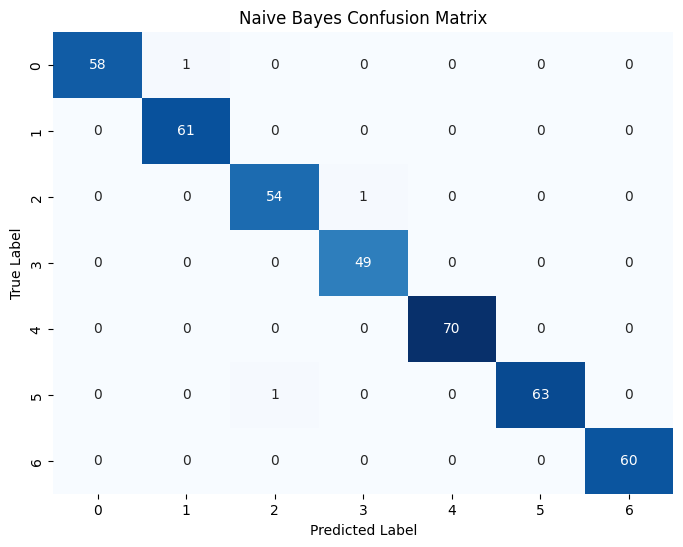

In [6]:
#________5: Naive Bayes_________

from sklearn.naive_bayes import GaussianNB

#define x and y
X = data.drop('obesity', axis=1)
y = data['obesity']

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#define the model
nb_model = GaussianNB()

#fit the model to the training data
nb_model.fit(X_train, y_train)

#predict the test set
y_pred_nb = nb_model.predict(X_test)
print(y_pred_nb)
print('-----------------')

#evaluate the model
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_cm = confusion_matrix(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", nb_accuracy)
print('-----------------')

#naive bayes confusion amtrix
plt.figure(figsize=(8, 6))
sns.heatmap(nb_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Naive Bayes Confusion Matrix")
plt.show()

In [7]:
#___6
#confirm that the model is not overfitting

#shuffle target labels
y_shuffled = np.random.permutation(y)

# Train and evaluate on shuffled data
nb_model.fit(X_train, y_shuffled[:len(X_train)])
y_pred_shuffled = nb_model.predict(X_test)
print("Accuracy on Shuffled Data:", accuracy_score(y_test, y_pred_shuffled))

Accuracy on Shuffled Data: 0.1339712918660287


In [8]:
#________7: Multilayer Perceptron Neural Network_________

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

#further split the training data into training and validation
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train,
                                                      test_size=0.25,
                                                      random_state=42)

#define the model
mlp_model = Sequential()
mlp_model.add(Input(shape=(58,))) #input layer
mlp_model.add(Dense(units=58, activation='relu')) #hidden layer
mlp_model.add(Dense(units=16, activation='relu')) #hidden layer
mlp_model.add(Dense(units=8, activation='softmax')) #output layer

#compile the model
mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

#train the model
mlp_history = mlp_model.fit(X_train_2,
                            y_train_2,
                            validation_data=(X_val, y_val),
                            epochs=100,
                            batch_size=32)

#evaluate the model
mlp_loss, mlp_accuracy = mlp_model.evaluate(X_test, y_test)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.2358 - loss: 2.0858 - val_accuracy: 0.4258 - val_loss: 1.6292
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4690 - loss: 1.4526 - val_accuracy: 0.6124 - val_loss: 1.1879
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6327 - loss: 1.0431 - val_accuracy: 0.7033 - val_loss: 0.8932
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7287 - loss: 0.7887 - val_accuracy: 0.7847 - val_loss: 0.6909
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8062 - loss: 0.6223 - val_accuracy: 0.8589 - val_loss: 0.5336
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8795 - loss: 0.4666 - val_accuracy: 0.8995 - val_loss: 0.4270
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9304 - loss: 0.3774 - val_accuracy: 0.9139 - val_loss: 0.3462
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9235 - loss: 0.3024 - val_accuracy: 0.9330 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 58)                  │           3,422 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,508 (52.77 KB)

 Trainable params: 4,502 (17.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,006 (35.18 KB)

None
--------------------
MLP Test Loss: 0.043578773736953735
MLP Test Accuracy: 0.9880383014678955
--------------------


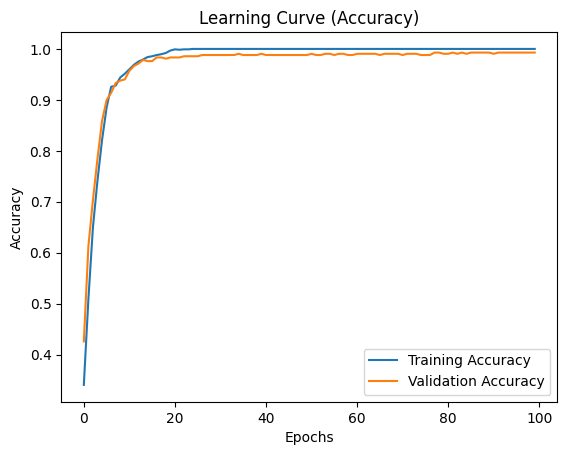

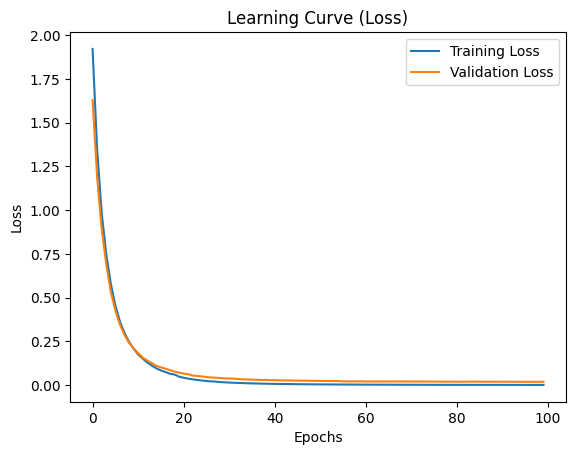

In [9]:
#____8
#accuracy of MLP nn

print(mlp_model.summary())
print('--------------------')

print('MLP Test Loss:', mlp_loss)
print('MLP Test Accuracy:', mlp_accuracy)
print('--------------------')

#plotting the accuracy and loss of the MLP model

#plot the learning curves for accuracy
plt.plot(mlp_history.history['accuracy'], label='Training Accuracy')
plt.plot(mlp_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#plot the learning curves for loss
plt.plot(mlp_history.history['loss'], label='Training Loss')
plt.plot(mlp_history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
#____9

#confirm that the model is not overfitting

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import numpy as np

# Shuffle target labels
y_shuffled = np.random.permutation(y)

# Further split the shuffled labels for consistency
y_shuffled_train, y_shuffled_test = train_test_split(y_shuffled, test_size=0.2, random_state=42)

# Ensure consistency with your earlier splits
y_shuffled_train_2, y_shuffled_val = train_test_split(y_shuffled_train, test_size=0.25, random_state=42)

# Define the model (same architecture)
mlp_model_shuffled = Sequential()
mlp_model_shuffled.add(Input(shape=(58,)))
mlp_model_shuffled.add(Dense(units=58, activation='relu'))  # Input layer
mlp_model_shuffled.add(Dense(units=16, activation='relu'))  # Hidden layer
mlp_model_shuffled.add(Dense(units=8, activation='softmax'))  # Output layer

# Compile the model
mlp_model_shuffled.compile(optimizer=Adam(learning_rate=0.001),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

# Train the model on shuffled labels
mlp_history_shuffled = mlp_model_shuffled.fit(X_train_2,
                                              y_shuffled_train_2,
                                              validation_data=(X_val, y_shuffled_val),
                                              epochs=100,
                                              batch_size=32,
                                              verbose=0)  # Silence output for faster debugging

# Evaluate the model on shuffled data
mlp_loss_shuffled, mlp_accuracy_shuffled = mlp_model_shuffled.evaluate(X_test, y_shuffled_test, verbose=0)

print(f"Accuracy on Shuffled Data: {mlp_accuracy_shuffled}")

Accuracy on Shuffled Data: 0.15550239384174347


In [11]:
#____10

#Accuracy Comparisons:

print("Random Classifier Accuracy:", baseline_accuracy)
print("Multinominal Logistic Regression Accuracy:", lr_accuracy)
print("Naive Bayes Accuracy:", nb_accuracy)
print('Test Accuracy:', mlp_accuracy)

Random Classifier Accuracy: 0.13157894736842105
Multinominal Logistic Regression Accuracy: 0.9784688995215312
Naive Bayes Accuracy: 0.992822966507177
Test Accuracy: 0.9880383014678955
